In [182]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import astropy
import astropy.table
import h5py
import os
from scipy.stats import binned_statistic as bs
import pyccl as ccl
from scipy.integrate import simps
from scipy.integrate import dblquad, quad
import time

%matplotlib inline 

First some necessary and boring preamble

In [116]:
os.chdir('/data/a/cpac/prlarsen/tests_dc2_lensing/')


def make_z_plot(z,s1,s2,cat_name):
    '''make s1(z) and s2(z) plots'''
    bn=50
    s1z, zedge, binn = bs(z, s1, bins=bn, statistic='mean')
    s2z, zedge, binn = bs(z, s2, bins=bn, statistic = 'mean')
    zvals = (zedge[1:]+zedge[:-1])/2.
    plt.plot(zvals,s1z,label='shear_1 '+cat_name)
    plt.plot(zvals,s2z,label='shear_2 '+cat_name)
    plt.plot(zvals,np.zeros(len(s1z)),'k--')
    plt.legend()
    return zvals, s1z, s2z

def make_z_bs(z,s1,s2):
    '''make binned statistic values for s1(z) and s2(z)'''
    bn=50
    s1z, zedge, binn = bs(z, s1, bins=bn, statistic='mean')
    s2z, zedge, binn = bs(z, s2, bins=bn, statistic = 'mean')
    zvals = (zedge[1:]+zedge[:-1])/2.
    return zvals, s1z, s2z

def get_shears_map(step='315'):
    '''read in shear values from the maps directly'''
    a00 = hp.read_map('rt_'+step+'_A1_2.fits',0);
    a01 = hp.read_map('rt_'+step+'_A1_2.fits',1);
    a10 = hp.read_map('rt_'+step+'_A2_2.fits',0);
    a11 = hp.read_map('rt_'+step+'_A2_2.fits',1);
    oct_mask = hp.read_map('mask_oct.fits');
    s1 = (a11-a00)/2.
    s2 = (a01+a10)/2.
    return s1,s2, oct_mask


s1m_315,s2m_315,mask_oct = get_shears_map('315')
s1m_247,s2m_247,mask_oct = get_shears_map('247')
s1m_163,s2m_163,mask_oct = get_shears_map('163')

gals_skysim = astropy.table.Table.read('/data/a/cpac/prlarsen/cori/skysim_full_z1_m23.fits')
gals_cutout = astropy.table.Table.read('/data/a/cpac/prlarsen/cori/cosmodc2_cutout_comp_z3_lowmag_27.fits')
gals_buzz = astropy.table.Table.read('/data/a/cpac/prlarsen/cori/buzzard_cutout_comp_z3_lowmag_27.fits')


pixs = np.unique(hp.ang2pix(4096,gals_cutout['RA'],gals_cutout['DEC'],lonlat=True))
mask_cutout = np.zeros(hp.nside2npix(4096))
mask_cutout[pixs] = 1.0

Now let's re-make the isotropic covariance using the correct cosmology and redshift distribution for the simulations (note the cosmology doesn't change much but the redshift distribution does peak significantly higher than predicted in the earlier notebook which increases the covariance).

In [192]:
cosmo = ccl.Cosmology(transfer_function='boltzmann_camb', matter_power_spectrum='halofit', Omega_c=0.26067, Omega_b=0.02242/0.6766**2,h=0.6766, n_s=0.9665, sigma8=0.8102)

z_buzz = np.loadtxt('../cori/nz_buzz.txt')
z_dc2 = np.loadtxt('../cori/nz_cdc2.txt')


nbins = 20
dz = 0.1
tracers_buzz = []
tracers_dc2 = []
ndens = []
for i in range(nbins):
    zb = z_buzz[0]; zc = z_dc2[0][1:]
    zr = np.array([i*dz, (i+1)*dz])
    msk_b = (zb >= zr[0]) & (zb < zr[1])
    msk_c = (zc >= zr[0]) & (zc < zr[1])
    nz_b = np.zeros_like(z_buzz[0])
    nz_c = np.zeros_like(z_dc2[0][1:])
    nz_b[msk_b] = z_buzz[1][msk_b]
    nz_c[msk_c] = z_dc2[1][1:][msk_c]
    tracers_buzz.append(ccl.WeakLensingTracer(cosmo,(zb, nz_b)))
    tracers_dc2.append(ccl.WeakLensingTracer(cosmo,(zc, nz_c)))
    
from scipy.special import jv
area_deg = 54.
# Equivalent angle in radians
theta_rad = np.radians(np.sqrt(area_deg/np.pi))
# Ells
ls = np.arange(1,2000)
wl = np.ones(2000-1)
wl[1:] = 2*jv(1,ls[1:]*theta_rad)/(ls[1:]*theta_rad)


In [120]:
cov_dc2 = np.zeros([nbins, nbins])

for i in range(nbins):
    for j in range(i, nbins):
        clee = ccl.angular_cl(cosmo, tracers_dc2[i], tracers_dc2[j], ls)
        cov_dc2[i, j] = np.sum(ls*wl**2*clee)/(4*np.pi)
        if i!=j:
            cov_dc2[j, i] = cov_dc2[i, j]


Now we have the theoretical covariance let's compare these to the map outputs

In [177]:
ram,decm = hp.pix2ang(4096,np.arange(hp.nside2npix(4096)),lonlat=True)
pixels2 = hp.ang2pix(8,ram,decm,lonlat=True)

mask_oct_8 = hp.ud_grade(mask_oct,nside_out=8)
s1m_315_8 = hp.ud_grade(s1m_315,nside_out=8)
s1m_247_8 = hp.ud_grade(s1m_247,nside_out=8)
s1m_163_8 = hp.ud_grade(s1m_163,nside_out=8)
s2m_315_8 = hp.ud_grade(s2m_315,nside_out=8)
s2m_247_8 = hp.ud_grade(s2m_247,nside_out=8)
s2m_163_8 = hp.ud_grade(s2m_163,nside_out=8)

vals1 = np.zeros((3,88))
vals1[0] = s1m_315_8[mask_oct_8==1.0]
vals1[1] = s1m_247_8[mask_oct_8==1.0]
vals1[2] = s1m_163_8[mask_oct_8==1.0]

vals2 = np.zeros((3,88))
vals2[0] = s2m_315_8[mask_oct_8==1.0]
vals2[1] = s2m_247_8[mask_oct_8==1.0]
vals2[2] = s2m_163_8[mask_oct_8==1.0]

zvals_new = np.zeros((3,88))
for i in range(88):
    zvals_new[:,i] = np.array([0.6,1.0,2.0])
    


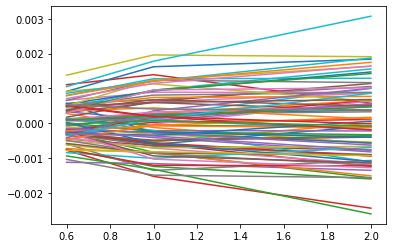

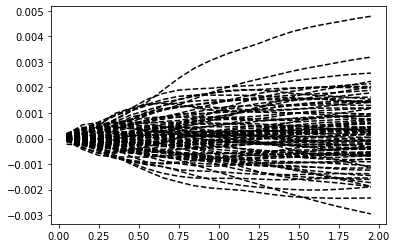

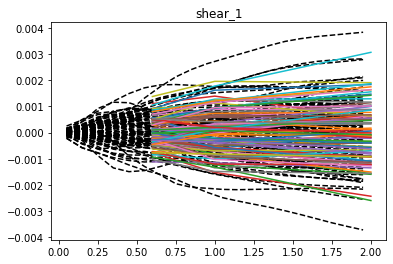

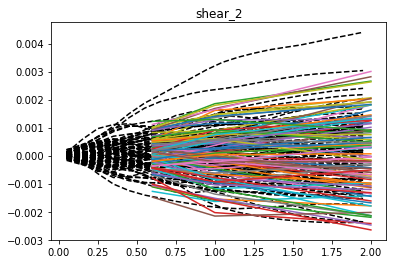

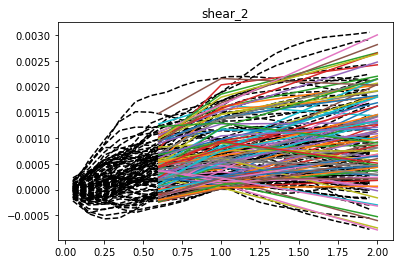

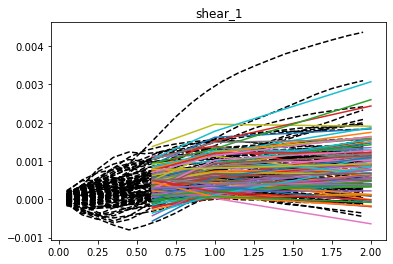

In [194]:
nsims=88

plt.plot(zvals_new,vals1);
plt.show()
plt.figure()
for i in range(nsims):
    gamma = np.random.multivariate_normal(np.zeros(nbins), cov_dc2)
    plt.plot(zbins, gamma,'k--')#*np.sign(gamma[nbins//2]))
plt.show()

plt.figure()
plt.title('shear_1')
for i in range(nsims):
    gamma = np.random.multivariate_normal(np.zeros(nbins), cov_dc2)
    plt.plot(zbins, gamma,'k--')#*np.sign(gamma[nbins//2]))
plt.plot(zvals_new,vals1)
plt.show()

plt.figure()
plt.title('shear_2')
for i in range(nsims):
    gamma = np.random.multivariate_normal(np.zeros(nbins), cov_dc2)
    plt.plot(zbins, gamma,'k--')#*np.sign(gamma[nbins//2]))
plt.plot(zvals_new,vals2)
plt.show()

plt.figure()
plt.title('shear_2')
for i in range(nsims):
    gamma = np.random.multivariate_normal(np.zeros(nbins), cov_dc2)
    plt.plot(zbins, gamma*np.sign(gamma[nbins//2]),'k--')
plt.plot(zvals_new,vals2*np.sign(vals2[1]))
plt.show()
plt.figure()
plt.title('shear_1')
for i in range(nsims):
    gamma = np.random.multivariate_normal(np.zeros(nbins), cov_dc2)
    plt.plot(zbins, gamma*np.sign(gamma[nbins//2]),'k--')
plt.plot(zvals_new,vals1*np.sign(vals1[1]))
plt.show()

At the map level things look pretty consistent with theory to first order. The sampling of the maps can have an impact on this, but at a positional level the covariances look consistent with theory. Let's do one last thing and pick the three pixels which overlap with the buzzard area and see if this is a particularly high region in either value 

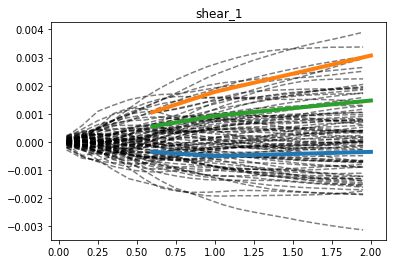

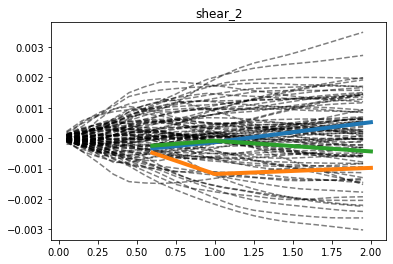

In [206]:
mask_cutout_8 = hp.ud_grade(mask_cutout,nside_out=8)

vals1b = np.zeros((3,3))
vals1b[0] = s1m_315_8[mask_cutout_8==1.0]
vals1b[1] = s1m_247_8[mask_cutout_8==1.0]
vals1b[2] = s1m_163_8[mask_cutout_8==1.0]

vals2b = np.zeros((3,3))
vals2b[0] = s2m_315_8[mask_cutout_8==1.0]
vals2b[1] = s2m_247_8[mask_cutout_8==1.0]
vals2b[2] = s2m_163_8[mask_cutout_8==1.0]

zvals_newb = np.zeros((3,3))
for i in range(3):
    zvals_newb[:,i] = np.array([0.6,1.0,2.0])


plt.figure()
plt.title('shear_1')
for i in range(nsims):
    gamma = np.random.multivariate_normal(np.zeros(nbins), cov_dc2)
    plt.plot(zbins, gamma,'k--',alpha=0.5)
plt.plot(zvals_newb,vals1b,lw=4)
plt.show()
plt.figure()
plt.title('shear_2')
for i in range(nsims):
    gamma = np.random.multivariate_normal(np.zeros(nbins), cov_dc2)
    plt.plot(zbins, gamma,'k--',alpha=0.5)
plt.plot(zvals_newb,vals2b,lw=4)
plt.show()




You can see that in this area shear_1 has a particularly high value, while shear_2 does not. This is consistent with what we see in the ouputs. In fact, the area we're looking at contains the highest outlier in shear_1 of the entire map, while the variance levels in the sub-pixels of the shear_2 area just about cancel their mean. In general this is consistent with what we've seen in cosmodc2 when validating lensing quantities in the past - this is an area of the sky that isn't particularly reflective of the average in the full octant.   

Looking at the plot below, this is the "truth" answer, which is consistent with the theory

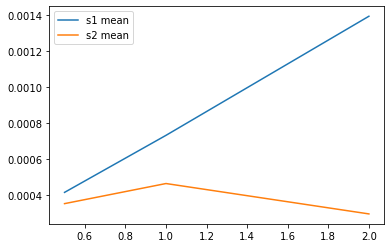

In [212]:
s1vals = np.array([np.mean(s1m_315[mask_cutout==1.0]),np.mean(s1m_247[mask_cutout==1.0]), np.mean(s1m_163[mask_cutout==1.0]) ])
s2vals = np.array([np.mean(s2m_315[mask_cutout==1.0]),np.mean(s2m_247[mask_cutout==1.0]), np.mean(s2m_163[mask_cutout==1.0]) ])
plt.figure()
plt.plot(zvals,s1vals,label='s1 mean')
plt.plot(zvals,-s2vals,label ='s2 mean') # making this positive just to compare more easily
plt.legend()
plt.show()

### Mean shifts and sampling biases

This shows the level of mean shift in skysim. This is a redshift-dependent mean shift which is roughly independent of area. It is not present in the maps, and is due to sampling from the lensing deflections. Here we overplot the cut out patch to see the level of impact that this has on the area. It does contribute but is sub-dominant to the variance effect. You can see the variance effect from the map values overplotted as dots, and that subtracting off the mean shift recovers the map values (approximately, this mean shift isn't perfectly computed, I should really be removing edge areas first and this has a magnitude cut of 23 which is why it breaks down at high redshifts). 

So there is some level of mean shift occuring, which will become noticeable when you look at very large areas. This area of 161 square degrees is a little small to see it, but it will have a slightly larger effect in the cosmoDC2 area. 


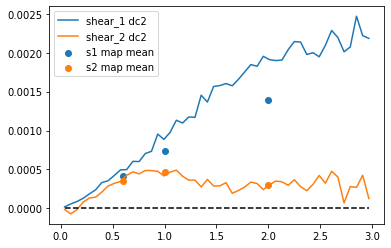

In [219]:
zvals, s1dc2, s2dc2 = make_z_plot(gals_cutout['REDSHIFT'],-gals_cutout['SHEAR1'],gals_cutout['SHEAR2'],'dc2')
plt.scatter(zvals_newb[:,0],s1vals,label='s1 map mean')
plt.scatter(zvals_newb[:,0],-s2vals,label ='s2 map mean') # making this positive just to compare more easily
plt.legend()
plt.show()

Now we can see that there is something of a mean shift in shear_1, this is due to a sampling bias which comes in from the lensing deflections. I am still looking into the cause of this and have some ideas as to why this might be the case. This mean shift is why shear_1 looks large when looking at the full skysim area. A simple way to remove this is to weight your galaxies to correct for the bias - the shear values in a given position will be correct so if you correct the sampling bias by either selective sampling or weighting your sample you can remove it. 

However correcting this mean shift is *not* going to make shear_1 and shear_2 have the same scatter in this patch, and it will not make the average shear_1 zero in this patch, nor will it remove an apparent redshift dependence. It will simply reduce it to the map level from a factor of ~6 difference to a factor of ~5 difference at z=2.  


Now we have the covariance questions out of the way let's look at the seagull plot

In [245]:
def make_sg_plot(s1,s2,cat_name):
    bn=500
    
    a, zedge, binn = bs(s1, s2, bins=bn, statistic='mean')
    a2, zedge2, binn = bs(s2, s1, bins=bn, statistic = 'mean')
    zvals = (zedge[1:]+zedge[:-1])/2.
    zvals2 = (zedge2[1:]+zedge2[:-1])/2.

    plt.title(cat_name)
    plt.plot(zvals,a,label='shear_2 ' + cat_name)
    plt.plot(zvals2,a2,label='shear_1 ' +cat_name)
    plt.xlim([-0.05,0.05])
    plt.ylim([-0.005,0.005])
    plt.plot(zvals2,np.zeros(len(a2)),'k--')
    plt.legend()
    return


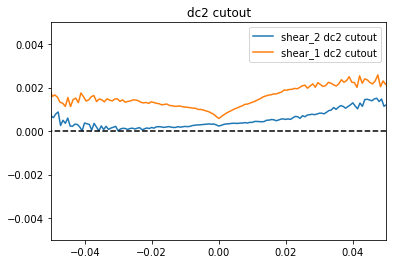

In [246]:
make_sg_plot(-gals_cutout['SHEAR1'],gals_cutout['SHEAR2'],'dc2 cutout')

Now let's think for a second - why are the values positive? Because in this area there is a mean value of shear_1 which is positive. Flipping this around and looking at the shear_2 plot, you see there is a much lower offset value, corresponding to the lower mean. Now why is there a peak here? Well low values of shear_1 and shear_2 aren't necessarily uncorrelated. While the phases should cancel out, low values could mean low redshifts with a lower mean value for instance. 

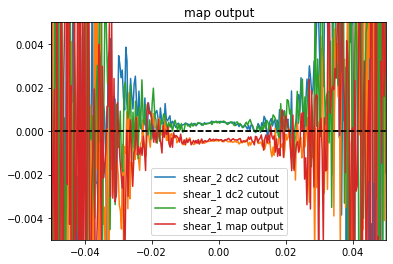

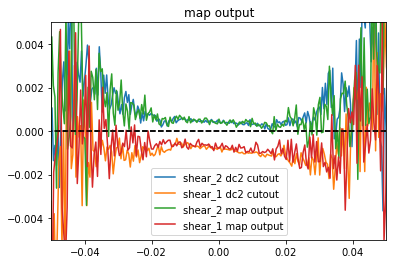

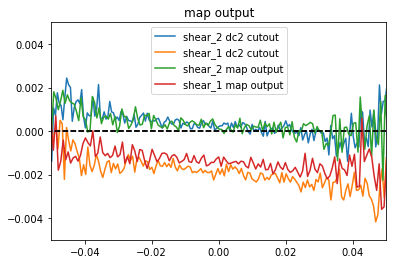

In [254]:
mask_red = (gals_cutout['REDSHIFT']>0.54)&(gals_cutout['REDSHIFT']<0.58) # about twice the redshift range of step 315
make_sg_plot(gals_cutout['SHEAR1'][mask_red],gals_cutout['SHEAR2'][mask_red],'dc2 cutout ')
make_sg_plot(-s1m_315[mask_cutout==1.0],-s2m_315[mask_cutout==1.0] ,'map output')
plt.show()
mask_red = (gals_cutout['REDSHIFT']>0.96)&(gals_cutout['REDSHIFT']<1.0) # about twice the redshift range of step 247
make_sg_plot(gals_cutout['SHEAR1'][mask_red],gals_cutout['SHEAR2'][mask_red],'dc2 cutout ')
make_sg_plot(-s1m_247[mask_cutout==1.0],-s2m_247[mask_cutout==1.0] ,'map output')
plt.show()

mask_red = (gals_cutout['REDSHIFT']>1.96)&(gals_cutout['REDSHIFT']<2.03) # about twice the redshift range of step 163
make_sg_plot(gals_cutout['SHEAR1'][mask_red],gals_cutout['SHEAR2'][mask_red],'dc2 cutout ')
make_sg_plot(-s1m_163[mask_cutout==1.0],-s2m_163[mask_cutout==1.0] ,'map output')
plt.show()

These again look consistent, and the seagull seems to be a feature of having a redshift-dependence in the mean. As the variance in the mean increases with redshift, despite the mean staying zero, this apparent redshift-dependence is not unusual in the draws from the covariance and would be expected to occur to some level in the sky. 

As this patch is one where this is particularly apparent it then may causes problems. A mean shift again would amplify this effect somewhat as it also causes a redshift dependence in the mean (you see that in the offset in shear_1 between the map output and the galaxies at z=2), but you should expect in any case to see seagull-like features in this patch.    